In [1]:
import numpy as np
import pandas as pd
import loompy
import matplotlib.pyplot as plt
from threadpoolctl import threadpool_limits, threadpool_info
import pickle
import yaml
from custom_functions import ixs_thatsort_a2b

threadpool_limits(limits=16)
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# First load the signatures extracted in previous studies 
signatures = pd.read_excel("signaturesFGF-TGF.xlsx")
tgfb_up = signatures["TGFB_UP"].dropna().values
tgfb_down = signatures["TGFB_DOWN"].dropna().values
fgf2_up = signatures["FGF2_UP"].dropna().values
fgf2_down = signatures["FGF2_DOWN"].dropna().values

# Make a dictionary to collect the signatures
signatures = {"tgfb_up": tgfb_up, "tgfb_down": tgfb_down, "fgf2_up": fgf2_up, "fgf2_down":fgf2_down}

# Analysis of the toxin-FACS data

In [3]:
# Load the bulk data on toxin-FACS sorted populations
dsbulk = loompy.connect("fibroblasts_sorted_bulk_RNAseq.loom")

In [4]:
# Boilerplate to have the data better organized

group_samples = {'1CRL':"CRL", '1ChTx':"ChTx", '1ChTxShTx1ShTx2':"ChTxShTx1ShTx2",
                 '1ShTx1ShTx2':"ShTx1ShTx2", '2CRL':"CRL", '2ChTx':"ChTx",
                 '2ChTxShTx1ShTx2':"ChTxShTx1ShTx2", '2ShTx1ShTx2':"ShTx1ShTx2",
                 '2ShTx2':"ShTx2", '3ChTxShTx1ShTx2':"ChTxShTx1ShTx2",
                 '3ShTx1ShTx2':"ShTx1ShTx2"}
sample_names = dsbulk.ca['sample']
samples_grouped = np.array([group_samples[i] for i in sample_names])
unique_populations, ix_populations = np.unique(samples_grouped, return_inverse=True)

## Preliminary procedures

In [5]:
# Equalize sample design by random sampling
np.random.seed(19900715)
p = np.array([1 / np.sum(ix_populations == i)/len(ix_populations) for i in ix_populations])
ix_adj = np.random.choice(np.arange(len(sample_names)), size=100, p=p/p.sum())

In [6]:
# Performe a very mild feature filtering
all_bulk = dsbulk[:,:]
boolf = (all_bulk[:, ix_adj] > 0).sum(1) > 0 
boolf = (all_bulk[:, ix_adj]).mean(1) > 1.5
boolf = (all_bulk[:, ix_adj] > 8).mean(1) > 0.15
all_bulk = all_bulk[boolf, :] 
all_genes = dsbulk.ra.Accession[boolf]

## Normalization

In [7]:
col_sums = all_bulk.sum(0)
bulk_sz = all_bulk / col_sums * np.mean(col_sums)
bulk_sz = bulk_sz + 1
bulk_pm = bulk_sz * 1e6 / bulk_sz.sum(0).mean()
bulk_norm = np.log2(bulk_pm)

In [8]:
# Boilerplate - Sort the data in a convenient way
ii = ixs_thatsort_a2b(sample_names,
                      np.array(['1CRL', '2CRL', '1ChTx', '2ChTx', '2ShTx2', '3ChTxShTx1ShTx2','1ChTxShTx1ShTx2',
                                '2ChTxShTx1ShTx2',  '3ShTx1ShTx2', '2ShTx1ShTx2', '1ShTx1ShTx2'], dtype=object))

In [10]:
## Aggregate by sample

bulk_sz = all_bulk / col_sums * np.mean(col_sums)

# Initialize empty Matrices
bulk_sz_agg = np.zeros((bulk_pm.shape[0], np.unique(ix_populations).shape[0]))
bulk_sz_rest_balanced = np.zeros((bulk_pm.shape[0], np.unique(ix_populations).shape[0]-1))

for i in np.unique(ix_populations):
    bulk_sz_agg[:,i] = bulk_sz[:, ix_populations == i].mean(1)
    
for i in range(len(np.unique(ix_populations))-1):
    bulk_sz_rest_balanced[:, i] = bulk_sz_agg[:, ~np.in1d(np.arange(bulk_sz_agg.shape[1]), [0, i+1])].mean(1)

bulk_pm_agg = bulk_sz_agg * 1e6 / bulk_sz_agg.sum(0).mean()
bulk_pm_agg += 1

bulk_pm_rest_balanced = bulk_sz_rest_balanced * 1e6 / bulk_sz_rest_balanced.sum(0).mean()
bulk_pm_rest_balanced += 1

In [11]:
# Reorder and log
order_wanted = np.array(['CRL', 'ChTx', 'ShTx2', 'ChTxShTx1ShTx2', 'ShTx1ShTx2'])
ixes = ixs_thatsort_a2b(unique_populations, order_wanted)
ixesb = ixs_thatsort_a2b(unique_populations[1:], order_wanted[1:])
sort_bulk_pm_agg = bulk_pm_agg[:, ixes]
bulk_pm_rest_balanced = bulk_pm_rest_balanced[:, ixesb]
sort_bulk_norm_agg = np.log2(sort_bulk_pm_agg)
sort_bulk_norm_balanced = np.log2(bulk_pm_rest_balanced)

In [12]:
# Get ENSBL -> gene_list conversion

# mysql  --user=genome --host=genome-mysql.cse.ucsc.edu -A -D hg19 -e "select distinct G.gene,N.value from ensGtp as G, ensemblToGeneName as N where G.transcript=N.name;" > ENS_genename.txt

In [13]:
df = pd.read_table("ENS_genename.txt")
ENS_sym = dict(zip(df.gene.values, df.value.values))

In [14]:
for i, pop_name in enumerate(order_wanted[1:]):
    obs = sort_bulk_norm_agg[:, i+1]
    rest = sort_bulk_norm_balanced[:, i]
    # consider only moderatelly expressed in at least one of the datasets
    filter1_ix = np.where(np.maximum(obs, rest) > 4.0)[0]
    obs = obs[filter1_ix]
    rest = rest[filter1_ix]
    filter2_ix = np.argsort(rest - obs)[:350]
    ixs = filter1_ix[filter2_ix]
    signatures[f"{pop_name}"] = np.array([ENS_sym[ens_id] if ens_id in ENS_sym else ens_id for ens_id in all_genes[ixs]])

# Save all signatures to file

In [16]:
pickle.dump(signatures, open("all_signatures.picke", "wb"))

# Plot a simple visualization

In [17]:
signature_names = ["ChTx", 'ChTxShTx1ShTx2', 'ShTx1ShTx2', 'ShTx2']
genes_to_show = np.concatenate([signatures[k][:8] for k in signature_names])
genes_to_show[-6:] = signatures["ShTx2"][3:9] # Do not plot ENSG00000280356, has no gene symbol, it is putative
all_genes_symbols = [ENS_sym[i] if i in ENS_sym else i for i in all_genes ]

In [18]:
ixes = np.array([all_genes_symbols.index(i) for i in genes_to_show])
values = bulk_pm_agg[:, 1:] - 1

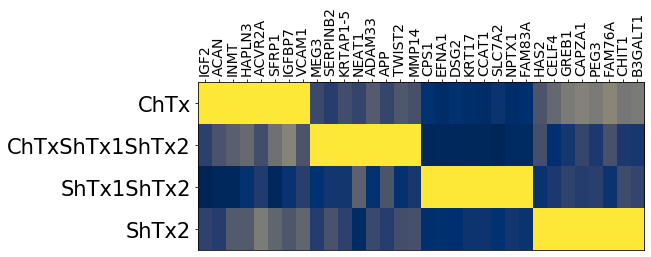

In [19]:
plt.figure(None, (8,8))
plt.imshow((values[ixes, :] / values[ixes, :].max(1)[:,None]).T, aspect=3, vmin=0, cmap=plt.cm.cividis)
plt.xticks(np.arange(len(ixes)), genes_to_show, fontsize=14, rotation=90);
plt.yticks(np.arange(len(signature_names)), signature_names, fontsize=21);
plt.gca().xaxis.tick_top()